In [94]:
import os,sys
os.chdir('C:/Users/arpit.goel/Documents/Projects/Kaggle/13.TrafficPrediction')
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt # to visualize data
from pandas.tools.plotting import autocorrelation_plot # to visualize and configure the parameters of ARIMA model
from statsmodels.tsa.arima_model import ARIMA # to make an ARIMA model that fits the data

df_train=pd.read_csv('train_aWnotuB.csv',parse_dates=['DateTime'])
df_test=pd.read_csv('test_BdBKkAj.csv',parse_dates=['DateTime'])

monthly_regression_params={1: [2.93, 18.59], 2: [0.9, 6.18], 3: [0.5, 8.65], 4: [0.17, 5.19]}

In [95]:
def get_vars(df):
    df['year']=df['DateTime'].dt.year
    df['month']=df['DateTime'].dt.month
    df['day']=df['DateTime'].dt.day
    df['hour']=df['DateTime'].dt.hour
    df['day_of_week']=df['DateTime'].dt.dayofweek
    df['flag_sunday']=(df['day_of_week']==6).astype(np.int64)
    df['flag_saturday']=(df['day_of_week']==5).astype(np.int64)
    df['flag_friday']=(df['day_of_week']==4).astype(np.int64)
    df['flag_monday']=(df['day_of_week']==0).astype(np.int64)
    df['flag_weekday']=(df['day_of_week']<=4).astype(np.int64)
    df['flag_junction_1']=(df['Junction']==1).astype(np.int64)
    df['flag_junction_2']=(df['Junction']==2).astype(np.int64)
    df['flag_junction_3']=(df['Junction']==3).astype(np.int64)
    df['flag_junction_4']=(df['Junction']==4).astype(np.int64)
    df['flag_last_day_of_month']=(df['day']==df['month'].map({1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31})).astype(np.int64)
    df['encoded_month']=12*df['year']+df['month']-24191
    df['date']=10000*df['year']+100*df['month']+df['day']
    df['encoded_date']=(df['DateTime']-date(2015,11,1)).dt.days
    slope=df['Junction'].map(lambda x: monthly_regression_params[x][0])
    intercept=df['Junction'].map(lambda x: monthly_regression_params[x][1])
    df['monthly_avg']=intercept+slope*df['encoded_month']
    return df

train=get_vars(df_train)
test=get_vars(df_test)



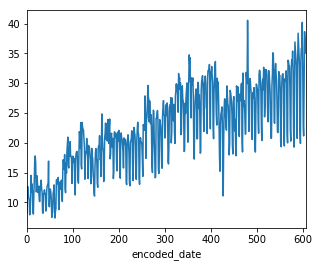

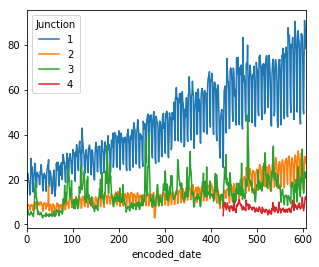

In [96]:
train.groupby(['encoded_date'])['Vehicles'].mean().plot(figsize=(5,4))
train.groupby(['encoded_date','Junction'])['Vehicles'].mean().unstack().plot(figsize=(5,4))
plt.show()

1


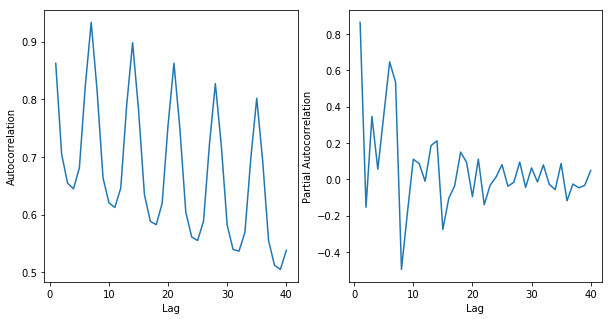

2


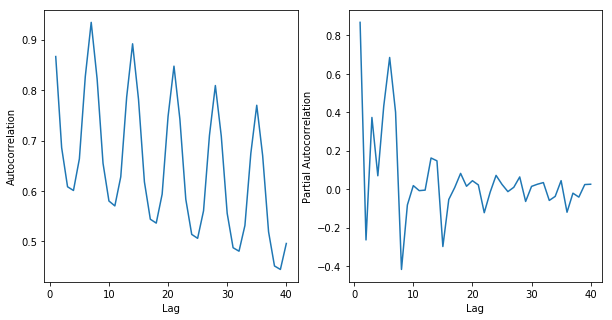

3


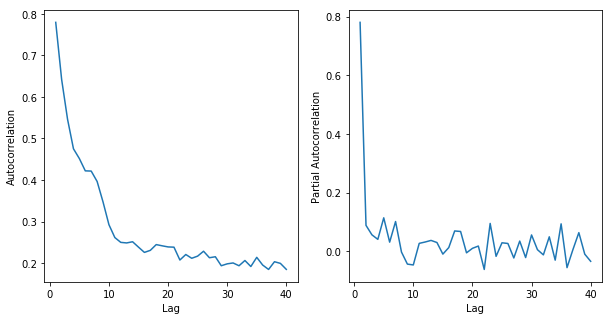

4


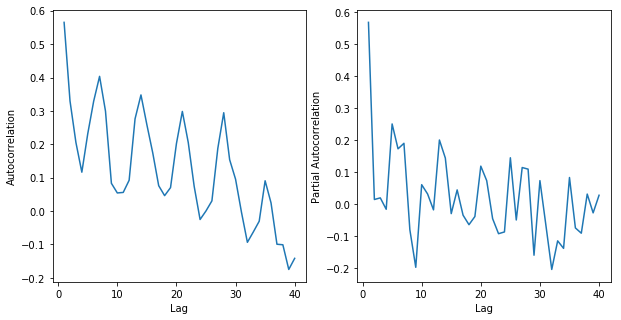

In [97]:
#Now we can plot Autocorrelation and Partial Autocorrelation graphs for all these languages, to estimate the hyperparameters used in training the ARIMA model.

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for name, group in train.groupby('Junction'):
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    data = np.array(group.groupby('encoded_date')['Vehicles'].mean())
    autocorr = acf(data)
    pac = pacf(data)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    print(name)
    plt.show()



1


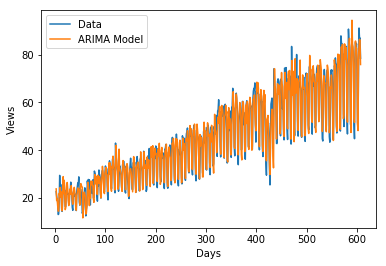

C:\Users\arpit.goel\AppData\Local\Continuum2\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2


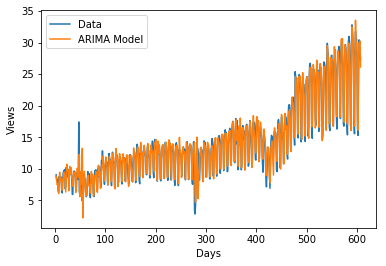

3


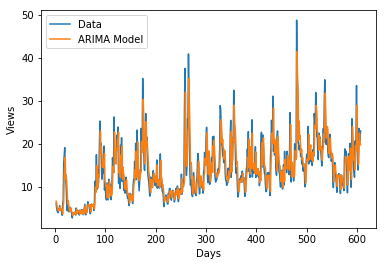

4


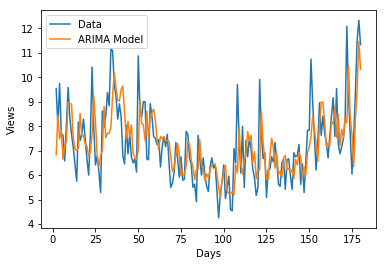

In [98]:
params = {1:[7,1,1],2:[7,1,1],3:[4,1,0],4:[7,1,1]}

train_pred=[]
test_pred=[]
for key, group in train.groupby('Junction'):
    data = np.array(group.groupby('encoded_date')['Vehicles'].mean())
    result = None
    arima = ARIMA(data,params[key])
    result = arima.fit(disp=False)
    #print(result.params)
    pred = result.predict(2,len(data)-1,typ='levels')
    train_pred.append(pd.Series([0,0]+list(pred),index=group['encoded_date'].drop_duplicates().sort_values()))
    x = range(len(data))
    print(key)
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()
    test_pred.append(result.predict(len(data),len(data)+122,typ='levels'))

In [99]:
arima_daily_predictions=pd.DataFrame(test_pred,index=[1,2,3,4],columns=map(int,range(608,731))).T.stack().to_dict()

In [100]:
test['Vehicles']=np.round(test.apply(lambda x: arima_daily_predictions[x['encoded_date'],x['Junction']],axis=1))
test[['ID','Vehicles']].to_csv('ArimaPrediction.csv',index=False)

In [101]:
arima_daily_predictions=pd.DataFrame(train_pred,index=[1,2,3,4]).T.stack().to_dict()
train['arima_prediction']=np.round(train.apply(lambda x: arima_daily_predictions[x['encoded_date'],x['Junction']],axis=1))

In [108]:
train['delta']=train['arima_prediction']-train['Vehicles']

In [109]:
train.groupby(['day_of_week','Junction'])['delta'].mean().unstack()

Junction,1,2,3,4
day_of_week,,,,
0,-2.116858,-0.665709,-1.105843,-1.008013
1,0.563697,0.236111,0.529693,-0.229167
2,-0.805077,-0.336207,0.019157,0.025641
3,0.497126,0.169061,-0.609674,-0.299679
4,-0.582375,-0.241379,-0.443008,-0.076923
5,1.027616,0.540698,-0.410853,0.293333
6,1.011973,0.189176,1.958812,0.516026
